In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import os
import json
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
    ]
)

train_dataset = datasets.MNIST(root='/content/',
                                train=True,
                                transform=transform,
                                download=True)

test_dataset = datasets.MNIST(root='/content/',
                                train=False,
                                transform=transform,
                                download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.03MB/s]


In [ ]:
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

In [ ]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, BATCH_SIZE, True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, False)

In [ ]:
class MNISTModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.fc1 = nn.Linear(input_shape, hidden_units)
    self.fc2 = nn.Linear(hidden_units, output_shape)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MNISTModel(784, 128, 10).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ForColab/model.pt'))

<All keys matched successfully>

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  model.train()
  true_predicts = 0
  train_losses = []
  val_losses = []
  train_loop = tqdm(train_loader, leave=False)
  for x, targets in train_loop:
    x = x.reshape(-1, 784).to(device)
    targets = targets.reshape(-1).to(torch.int32)
    targets = torch.eye(10)[targets].to(device)

    predict = model.forward(x)
    loss = loss_function(predict, targets)

    optimizer.zero_grad() # обнуляем ранее вычисленные градиенты
    loss.backward() # обратный проход по вычисленной функции потерь
    optimizer.step() # корректировка параметров

    train_losses.append(loss.item())
    mean_train_loss = sum(train_losses) / len(train_losses)

    true_predicts += (predict.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

    train_loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]: train_loss={mean_train_loss:.4f}")

  # Точность на текущей эпохе
  epoch_train_accuracy = true_predicts / len(train_dataset)

  model.eval()
  with torch.no_grad(): # запрещаем вычисление градиентов внутри
    for x, targets in val_loader:
      x = x.reshape(-1, 784).to(device)
      targets = targets.reshape(-1).to(torch.int32)
      targets = torch.eye(10)[targets].to(device)

      predict = model.forward(x)
      loss = loss_function(predict, targets)

      val_losses.append(loss.item())
      mean_val_loss = sum(val_losses) / len(val_losses)

      train_loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]: val_loss={mean_val_loss:.4f}")

    # Точность на текущей эпохе
    epoch_val_accuracy = true_predicts / len(val_dataset)

    print(f"Result in [{epoch + 1}/{EPOCHS}] epoch: train_loss={mean_train_loss:.4f}, train_acc={epoch_train_accuracy:.4f}, val_los={mean_val_loss:.4f}, val_acc={epoch_val_accuracy:.4f}")
    print()


Result in [1/10] epoch: train_loss=0.3406, train_acc=0.8979, val_los=0.2080, val_acc=3.5916



Result in [2/10] epoch: train_loss=0.1784, train_acc=0.9460, val_los=0.1508, val_acc=3.7841



Result in [3/10] epoch: train_loss=0.1359, train_acc=0.9593, val_los=0.1356, val_acc=3.8373



Result in [4/10] epoch: train_loss=0.1155, train_acc=0.9645, val_los=0.1327, val_acc=3.8581



Result in [5/10] epoch: train_loss=0.1011, train_acc=0.9685, val_los=0.1172, val_acc=3.8740



Result in [6/10] epoch: train_loss=0.0918, train_acc=0.9707, val_los=0.1309, val_acc=3.8829



Result in [7/10] epoch: train_loss=0.0814, train_acc=0.9739, val_los=0.1330, val_acc=3.8954



Result in [8/10] epoch: train_loss=0.0760, train_acc=0.9752, val_los=0.1289, val_acc=3.9008



Result in [9/10] epoch: train_loss=0.0726, train_acc=0.9769, val_los=0.1202, val_acc=3.9078



Result in [10/10] epoch: train_loss=0.0673, train_acc=0.9785, val_los=0.1125, val_acc=3.9142



In [ ]:
torch.save(model.state_dict(), '/content/torch_model.pt')
!cp /content/torch_model.pt /content/drive/MyDrive/ForColab/

In [ ]:
model.eval()

true_predicts = 0

with torch.no_grad(): # запрещаем вычисление градиентов внутри
  for x, targets in test_loader:
    x = x.reshape(-1, 784).to(device)
    targets = targets.reshape(-1).to(torch.int32)
    targets = torch.eye(10)[targets].to(device)

    predict = model.forward(x)
    true_predicts += (predict.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

In [ ]:
acc = true_predicts / len(test_dataset) * 100
print(f"Точность на тестовой выбокре: {acc:.2f}.")

Точность на тестовой выбокре: 96.98.


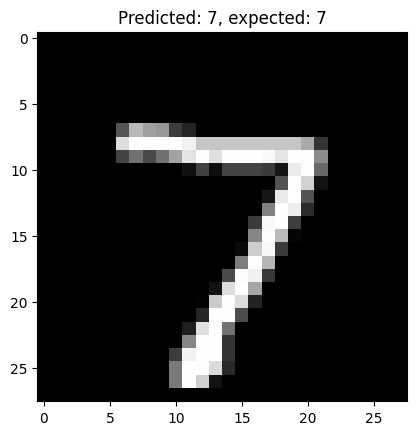

In [ ]:
model.eval()

x, target = test_dataset[0]
x = x.reshape(-1, 784).to(device)

with torch.no_grad():
    predict = model.forward(x)

x_cpu = x.cpu().reshape(28, 28)

plt.imshow(x_cpu, cmap='gray')
plt.title(f'Predicted: {predict.argmax(dim=1).item()}, expected: {target}')
plt.show()